# ADS 505: Applied Data Science for Business

### Final Team Project

### Team 4: Jun Sik Ryu, Cynthia Portales-Loebell, and Akshat Patni

#### October 13, 2025

#### Dataset: WA_Fn-UseC_-Telco-Customer-Churn.csv

### Import Libraries & Configure Settings

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, roc_auc_score, mean_squared_error, mean_absolute_error, 
precision_score, recall_score, f1_score, ConfusionMatrixDisplay, 
RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.base import ClassifierMixin
from sklearn.inspection import permutation_importance

### Load Data 

In [18]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

## 1. Problem Statement and Business Objective

The objective is to predict customer churn (attrition) in the next billing cycle for an active customer base using the Telco-Customer-Churn.csv dataset. 

By applying supervised machine learning models to customer behavioral and demographic data, this analysis aimed to predict churn probability for each customer and provide actionable insights for targeted retention campaigns. A predictive model that effectively identifies at-risk customers enables the business to implement proactive outreach, discount offers, or loyalty programs to retain valuable clients.

In [19]:
# Dataset overview
print(df.shape)
df.head()
df.info()

(7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null

## 2. Data Description

The dataset contained approximately **7043** observations and **21** features representing customer demographics, service usage, billing information, and churn status.  

Key variables included:  
- **Target Variable:** `Churn` – 1 if the customer left, 0 otherwise.  
- **Predictors:** were the:  
Tenure – Number of months with the company  
Service Subscriptions – e.g. PhoneService, InternetService, OnlineSecurity, StreamingTV.  
Account Information – e.g. Contract, PaymentMethod, PaperlessBilling.  
Charge Details – MonthlyCharges, TotalCharges.  
  
Initial inspection revealed a mild class imbalance, with roughly **26.5**% churned customers. Some numerical features exhibited skewness, and categorical variables required encoding for model readiness. No severe multicollinearity was detected, and missing values were handled through appropriate imputation or removal.



### Exploratory Data Analysis

In [20]:
# Info summary
df.info()

# Summary statistics
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


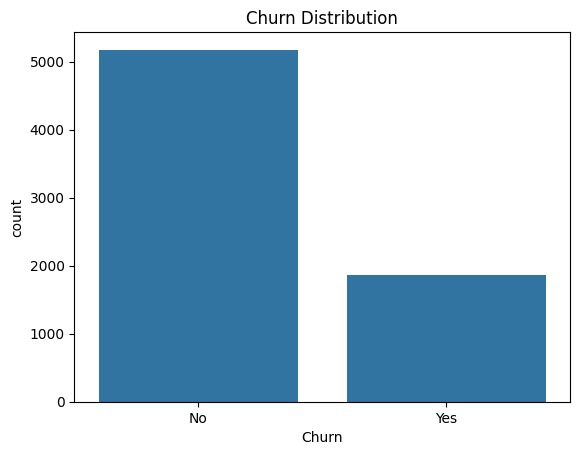

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

In [21]:
# Target variable countplot
sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.show()

# Percentage
df["Churn"].value_counts(normalize=True) * 100

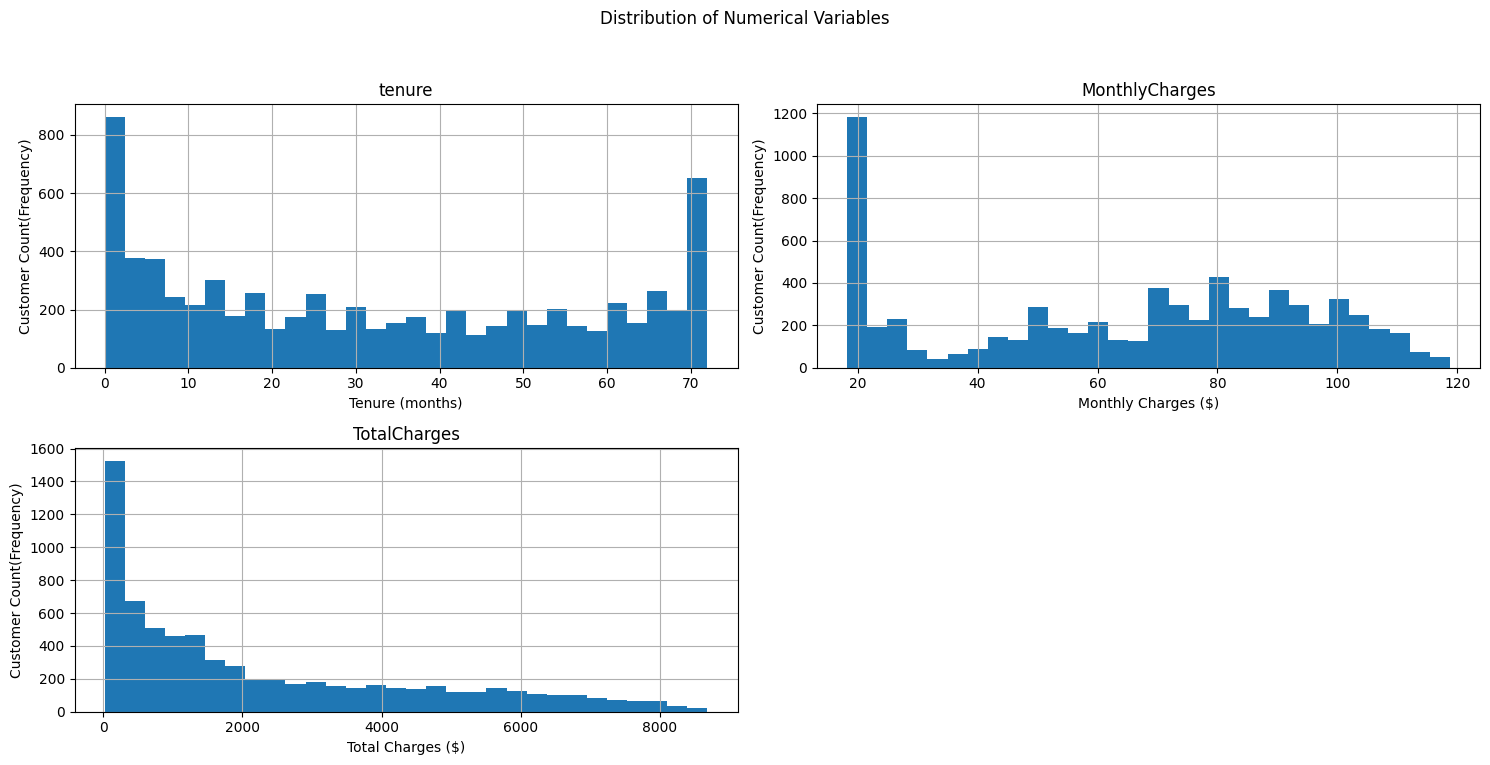

In [34]:
# Distribution of numerical variables

num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

x_labels = {
    "tenure": "Tenure (months)",
    "MonthlyCharges": "Monthly Charges ($)",
    "TotalCharges": "Total Charges ($)"
}

axes = df[num_cols].hist(bins=30, figsize=(15, 8))

for ax in axes.flatten():
    column_name = ax.get_title()
    if column_name in x_labels:
        ax.set_xlabel(x_labels[column_name])
        ax.set_ylabel("Customer Count(Frequency)")


plt.suptitle("Distribution of Numerical Variables")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

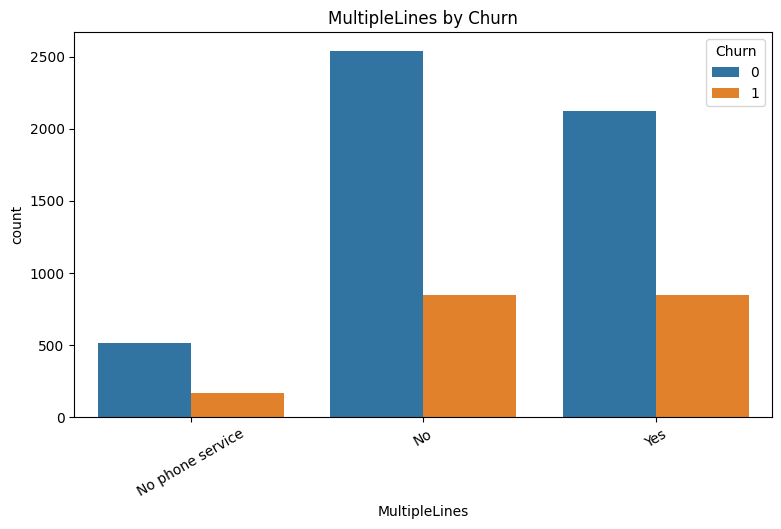

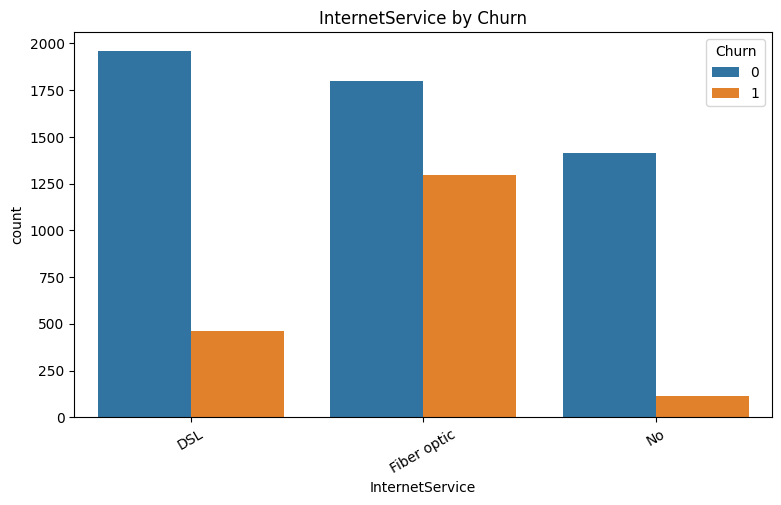

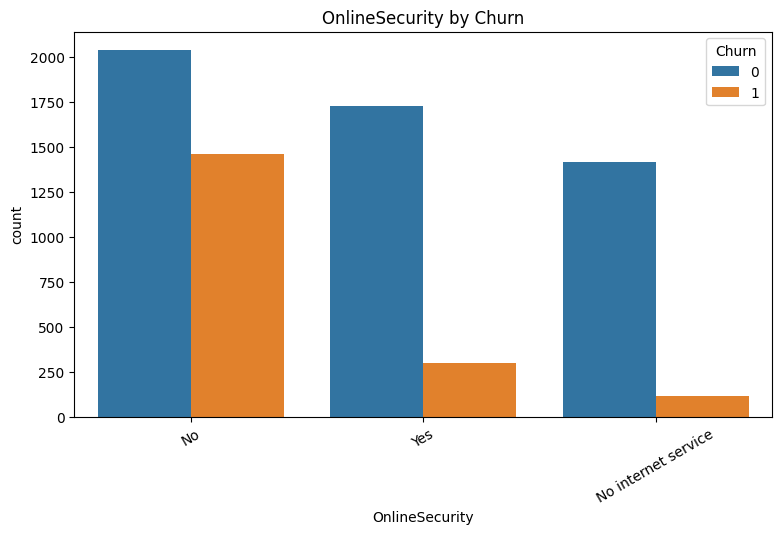

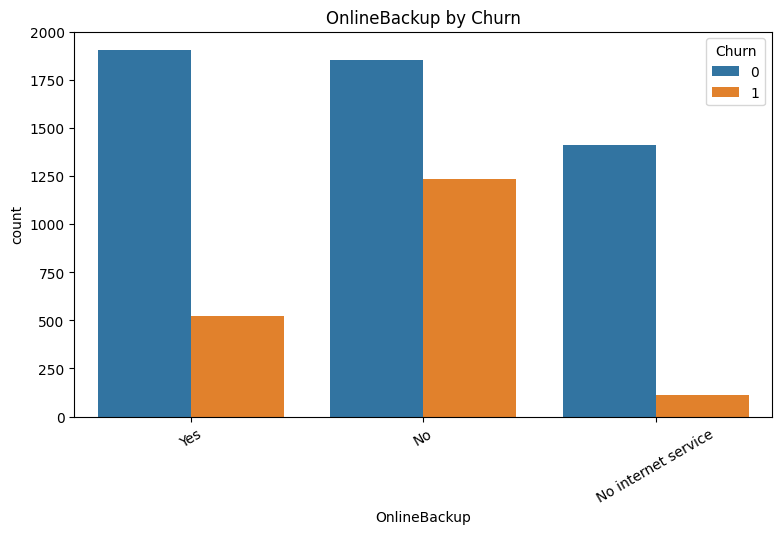

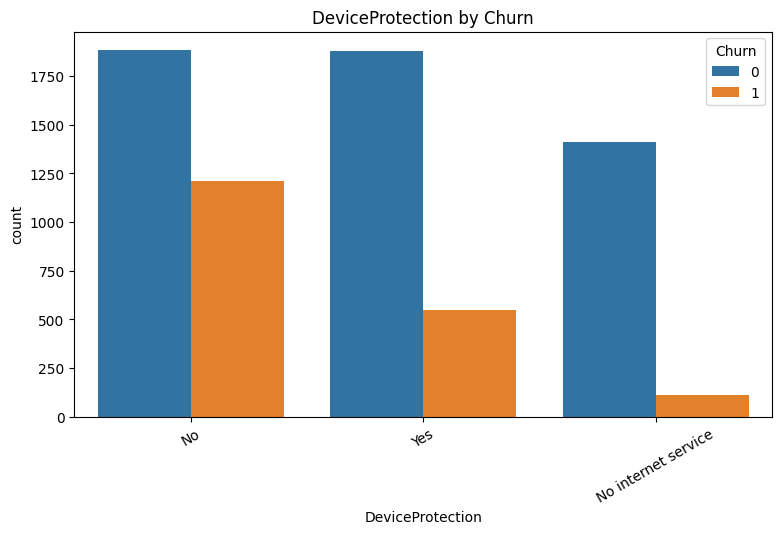

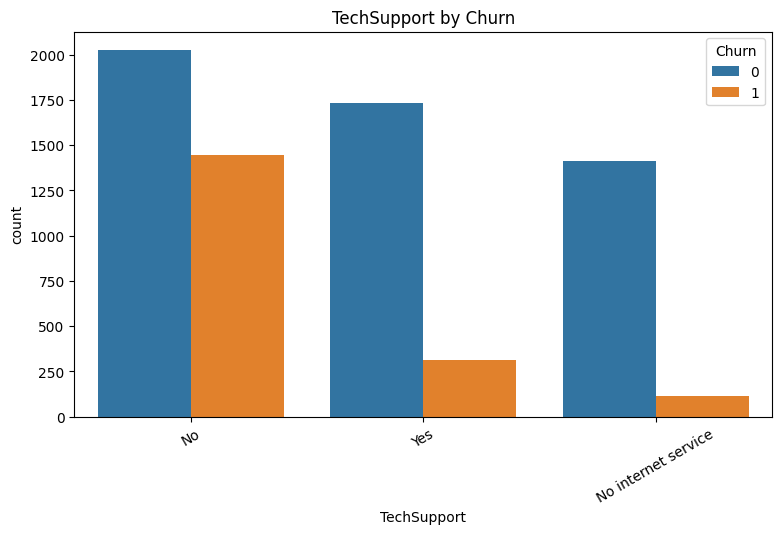

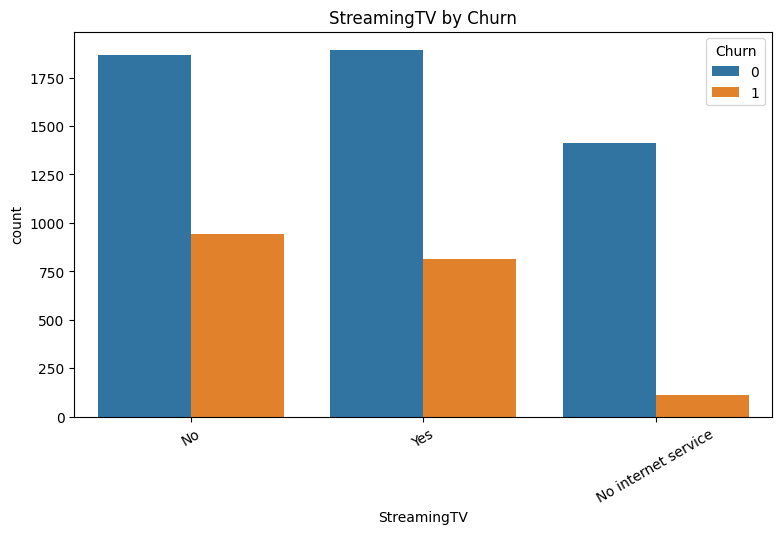

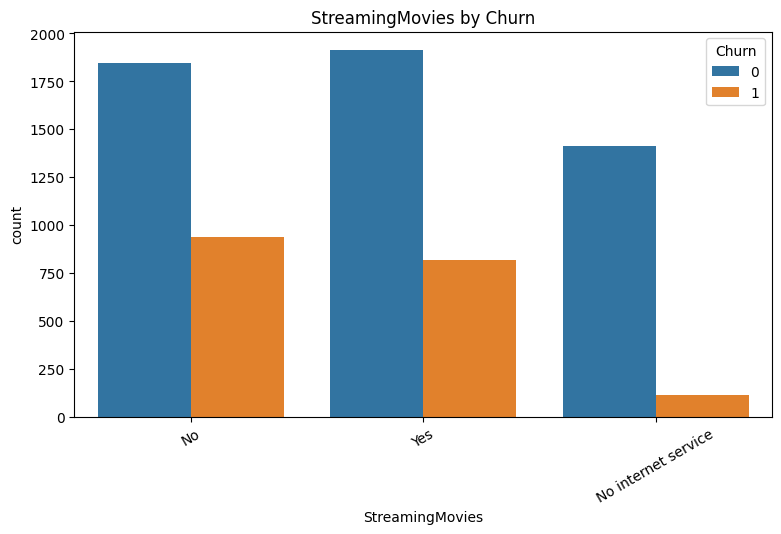

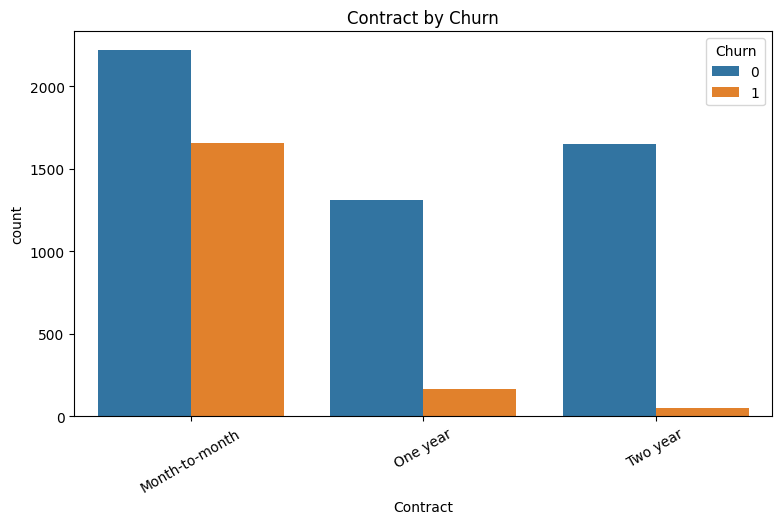

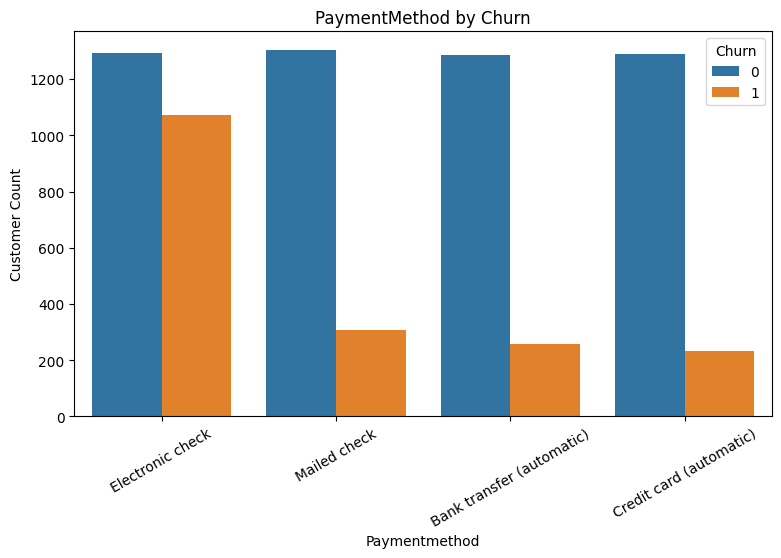

In [35]:
# Distribution of categorical variables

cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_cols = [col for col in cat_cols if col not in ["customerID", "Churn", "TotalCharges"]] # Remove unnecessary columns

# Barplots for categorical variables vs churn
for col in cat_cols:
    plt.figure(figsize=(9,5))
    sns.countplot(x=col, hue="Churn", data=df)
    plt.title(f"{col} by Churn")
    plt.xticks(rotation=30)

plt.xlabel(col.replace("_", " ").title())
plt.ylabel("Customer Count")

plt.show()

## 3. Exploratory Data Analysis (EDA)

EDA revealed distinct behavioral differences between retained and churned customers.  

Key findings included:
- Dataset Structure and Initial Data Types: The dataset contains a total of 7043 entries across 21 columns. Most of these columns are categorical, with 18 columns initially identified as object types, while only three columns were numerical (2 int64 and 1 float64).  
- Target Variable Imbalance: A significant finding was the distribution of the target variable, Churn. The data is imbalanced, showing that 73.46% of customers did not churn ("No"), compared to 26.54% of customers who did churn ("Yes").  
- Data Quality Issue in TotalCharges: Although most columns had 7043 non-null entries, the TotalCharges column was initially identified as an object data type. Subsequent checks revealed that this column contained 11 missing values (blanks as spaces), necessitating conversion to numeric and imputation during the preprocessing stage.  
- Average Customer Tenure: The descriptive statistics for the numerical variables showed that the average customer tenure is approximately 32.37 months.
- Average Monthly Charges: The mean MonthlyCharges across the customer base was determined to be approximately 64.76.  


### Data Preprocessing

In [24]:
# Handle Missing Values

# Convert TotalCharges to numeric (has blanks as spaces)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["tenure"] = pd.to_numeric(df["tenure"], errors="coerce")
df["MonthlyCharges"] = pd.to_numeric(df["MonthlyCharges"], errors="coerce")

# Check missing values
print(df.isnull().sum())

# Impute with median
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [25]:
# Engineer new derived features

# Binary encoding for target
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0}).astype(int)

# Binary categorical columns mappings
binary_mappings = {
    "gender": {"Female": 1, "Male": 0},
    "SeniorCitizen": {1: 1, 0: 0},
    "Partner": {"Yes": 1, "No": 0},
    "Dependents": {"Yes": 1, "No": 0},
    "PhoneService": {"Yes": 1, "No": 0},
    "PaperlessBilling": {"Yes": 1, "No": 0}
}

# Apply mapping
for col, mapping in binary_mappings.items():
    df[col] = df[col].map(mapping)

# Flag high-value customers
df["HighValueCustomer"] = ((df["tenure"] > 50) & (df["MonthlyCharges"] > 70)).astype(int)

#Has multiple services? 
services_truthy_map = {
    "InternetService": ["DSL", "Fiber optic"],
    "PhoneService": ["Yes"],
    "OnlineSecurity": ["Yes"],
    "OnlineBackup": ["Yes"],
    "DeviceProtection": ["Yes"],
    "TechSupport": ["Yes"],
    "StreamingTV": ["Yes"],
    "StreamingMovies": ["Yes"]
}

df["NumServices"] = df.apply(
    lambda row: sum(row[col] in services_truthy_map[col] for col in services_truthy_map),
    axis=1)
df["HasMultipleServices"] = (df["NumServices"] >= 3).astype(int)

In [26]:
# Numeric & categorical pipelines for preprocessing

# Multi-class categorical columns
multi_class_cols = [
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaymentMethod"
]

num_cols = ["tenure", "MonthlyCharges", "TotalCharges", "NumServices"]

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, multi_class_cols)
], remainder="passthrough")

## 4. Data Pre-processing

Data cleaning and preparation steps were performed to ensure model integrity and comparability:

1. **Missing Values:** Missing values in TotalCharges (initially 11 missing values) were handled by imputing them with the median. The numerical pipeline (num_pipe) was set up to use SimpleImputer with a median strategy for numerical columns. The categorical pipeline (cat_pipe) was set up to use SimpleImputer with a most frequent strategy for multi-class categorical columns
   
2. **Feature Engineering**: New engineered features were added to capture customer value and scope of their use/preference for the offered services. The feature `HighValueCustomer` is a boolean flag that identifies customers with long tenures and high monthly charges, representing loyal and high spending customers. The feature `NumServices` captures the total number of offered services a given customer uses, measuring their loyalty and preference for the brand, and `HasMultipleServices` is a boolean flag that segments the population based on the number of services.
   
3. **Encoding:** Converted categorical variables (e.g., gender, payment method, contract type) using encoding methods. For multi-class categorical variables, one-hot encoding was applied. Binary encoding was applied to Target & Binary Columns: The target variable Churn was converted to a numerical binary format (Yes: 1, No: 0)  
4. **Scaling:** Numerical features were normalized using StandardScaler. This was implemented within the num_pipe. The numerical features included tenure, MonthlyCharges, TotalCharges, and the engineered feature NumServices.  

5. **Integrated Transformation Pipeline:** Preprocessing methods were applied using a ColumnTransformer to assert identical transformations across data partitions and model pipelines. 

### Split/Prepare Data for Modeling

In [27]:
# Train-test split

X = df.drop(["Churn", "customerID"], axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Training set:", X_train.shape, "Testing set:", X_test.shape)

Training set: (4930, 22) Testing set: (2113, 22)


## 5. Data Splitting

The cleaned dataset was divided into: 
- **Training Set**: 70%
- **Test Set**: 30%

Splitting was stratified by the target variable `Churn` to maintain consistency with the observed class imbalance since a positive churn value makes up only 26% of the overall data population. The random state was also fixed for reproducibility. The training set was subsequently applied for model development while the test set was used later for model evaluation. 

## 6. Model Strategies 

Given the objective to predict and identify customers most likely to discontinue service, the modeling approaches were selected to perform supervised classification, balancing predictive strength with interpretability. The three classification algorithms chosen were as follows: 

The goal was to identify customers most likely to discontinue service using models that balance interpretability and predictive strength. Three supervised classification algorithms were developed within unified preprocessing pipelines:

1. **Logistic Regression**
- Provides a baseline, highly interpretable model
- Effective at identifying linear relationships between predictor variables and `Churn` outcome
- PCA was applied via model pipeline, n_components value was optimized through grid search
- Hyperparameters such as regulization strength and solver were tuned through grid search
   
2. **Random Forest**
- Ensemble model of highly flexible decision trees effectively captures non linear interactions and intrinsically identifies feature importance
- Various hyperparameters such as # of estimators, depth, splitting samples, etc. were tuned through grid search
   
3. **XGBoost**
- Gradient boosting trees strongly optimizes prediction performance for imbalanced classification cases
- Also tuned similar hyperparameters through grid search
- Implemented log loss optimization for regularization

In [28]:
# Logistic Regression pipeline (with PCA)
lr_pipe = Pipeline([
    ("prep", preprocess),
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=None))
])

lr_params = {
    "pca__n_components": [0.9, 0.95, 0.99],
    "clf__C": [0.1, 1, 5],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"]
}

# Random Forest pipeline
rf_pipe = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(random_state=42))
])

rf_params = {
    "clf__n_estimators": [300, 600],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 10],
    "clf__min_samples_leaf": [1, 5],
    "clf__class_weight": [None, "balanced"]
}

# XGBoost pipeline
xgb_pipe = Pipeline([
    ("prep", preprocess),
    ("clf", XGBClassifier(
        random_state=42,
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        n_jobs=-1
    ))
])

xgb_params = {
    "clf__n_estimators": [300, 600],
    "clf__learning_rate": [0.03, 0.05, 0.1],
    "clf__max_depth": [3, 4, 6],
    "clf__subsample": [0.7, 0.9],
    "clf__colsample_bytree": [0.7, 0.9]
}

#Cross Validation Grids to select optimal model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grids = [
    GridSearchCV(lr_pipe, lr_params, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True),
    GridSearchCV(rf_pipe, rf_params, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True),
    GridSearchCV(xgb_pipe, xgb_params, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True),
]

#### Train models

In [29]:
#Iterate through grid search CV to select optimal model for each model type
#Then train optimal model on training data

#Logistic Regression Model
lr_grid = grids[0].fit(X_train, y_train)
lr_model = lr_grid.best_estimator_.fit(X_train, y_train)

#Random Forest Model
rf_grid = grids[1].fit(X_train, y_train)
rf_model = rf_grid.best_estimator_.fit(X_train, y_train)

#XGBoost Model 
xgb_grid = grids[2].fit(X_train, y_train)
xgb_model = xgb_grid.best_estimator_.fit(X_train, y_train)

print("LR Best CV ROC-AUC:", round(lr_grid.best_score_, 3))
print("RF Best CV ROC-AUC:", round(rf_grid.best_score_, 3))
print("XGB Best CV ROC-AUC:", round(xgb_grid.best_score_, 3))

LR Best CV ROC-AUC: 0.845
RF Best CV ROC-AUC: 0.847
XGB Best CV ROC-AUC: 0.848


## 7. Validation & Testing

**5-fold Stratified Cross validation:** Implemented in order to reduce overfitting during training and reliably evaluate model performance for optimization and hyperparameter tuning. 

**GridSearch Cross Validation:** Trains each model using iterated combinations of hyperparameter values. Training iterations performed to optimize for ROC-AUC scoring so that the model is generalizable regardless of the classification threshold and effectively separates the target classes. This is more effective than optimizing for accuracy since a high accuracy can be misleading in datasets with significant class imbalance. 

**Performance evaluation**: After tuning, the best estimator for each model was fit on the complete training set. The optimized ROC-AUC scores for each model on the training set was measured. This showed that XGBoost had the best score by a slight margin compared to the other two models, indicating that it will have the best predictive capability and generalizability.

### Model Evaluation & Performance Metrics

#### Final Model Selection

In [30]:
candidates = []
if 'lr_grid' in globals() and hasattr(lr_grid, "best_estimator_"):
    candidates.append(("LogReg", lr_grid.best_estimator_, getattr(lr_grid, "best_score_", np.nan)))
if 'rf_grid' in globals() and hasattr(rf_grid, "best_estimator_"):
    candidates.append(("RandomForest", rf_grid.best_estimator_, getattr(rf_grid, "best_score_", np.nan)))
if 'xgb_grid' in globals() and hasattr(xgb_grid, "best_estimator_"):
    candidates.append(("XGBoost", xgb_grid.best_estimator_, getattr(xgb_grid, "best_score_", np.nan)))

if not candidates:
    if 'lr' in globals() and hasattr(lr, "predict"): candidates.append(("LogReg", lr, np.nan))
    if 'rf' in globals() and hasattr(rf, "predict"): candidates.append(("RandomForest", rf, np.nan))
    if 'xgb' in globals() and hasattr(xgb, "predict"): candidates.append(("XGBoost", xgb, np.nan))

if not candidates:
    raise RuntimeError("No fitted models found—run training/grid search first.")

model_name, model, cv_auc = max(candidates, key=lambda t: (t[2] if t[2]==t[2] else -1))
print(f"Selected: {model_name}" + (f" (CV ROC-AUC={cv_auc:.3f})" if cv_auc==cv_auc else ""))

Selected: XGBoost (CV ROC-AUC=0.848)


In [31]:
# Best hyperparameters for the selected model
print("Best params (XGBoost):", xgb_grid.best_params_)
print("CV ROC-AUC:", round(xgb_grid.best_score_, 3))

Best params (XGBoost): {'clf__colsample_bytree': 0.9, 'clf__learning_rate': 0.03, 'clf__max_depth': 3, 'clf__n_estimators': 300, 'clf__subsample': 0.7}
CV ROC-AUC: 0.848


#### Test-Set Performance
##### Metric Summary (Accuracy / Precision / Recall / F1 / ROC-AUC)

In [32]:
y_true = y_test
y_true_num = pd.Series(y_true).map({"No":0,"Yes":1}) if pd.Series(y_true).dtype=='O' else pd.Series(y_true)

y_pred  = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

metrics = {
    "Accuracy":  accuracy_score(y_true_num, y_pred),
    "Precision": precision_score(y_true_num, y_pred, zero_division=0),
    "Recall":    recall_score(y_true_num, y_pred, zero_division=0),
    "F1":        f1_score(y_true_num, y_pred, zero_division=0),
    "ROC_AUC":   roc_auc_score(y_true_num, y_proba) if y_proba is not None else np.nan
}
metrics_df = pd.DataFrame(metrics, index=["Score"]).T
display(metrics_df.style.format("{:.3f}"))

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

*Among customers flagged as churners,  about 66% actually churn (precision), and we capture about 51% of true churners (recall). However, it's worth noting that because churn is imbalanced, ROC-AUC, Recall, Precision, and F1 are more informative than Accuracy alone.*

##### Confusion Matrix & Classification Report

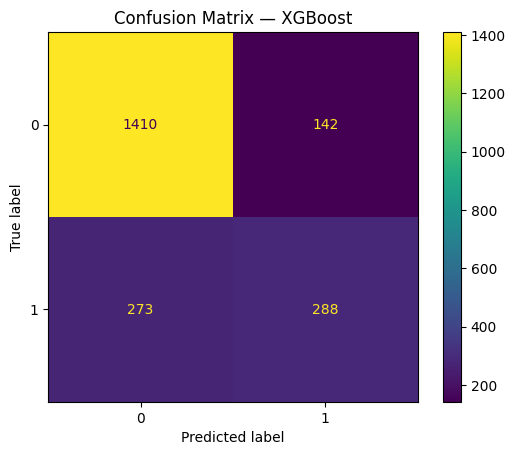

              precision    recall  f1-score   support

    No churn       0.84      0.91      0.87      1552
       Churn       0.67      0.51      0.58       561

    accuracy                           0.80      2113
   macro avg       0.75      0.71      0.73      2113
weighted avg       0.79      0.80      0.79      2113



In [ ]:
ConfusionMatrixDisplay.from_predictions(y_true_num, y_pred, display_labels=[0,1])
plt.title(f"Confusion Matrix — {model_name}")
plt.show()

print(classification_report(y_true_num, y_pred, target_names=["No churn","Churn"]))

##### ROC & Precision–Recall Curves

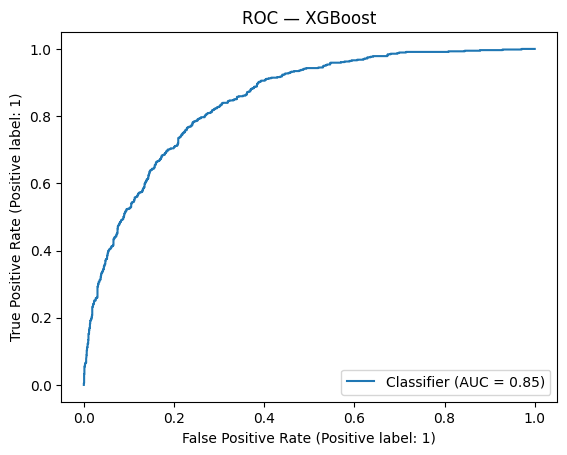

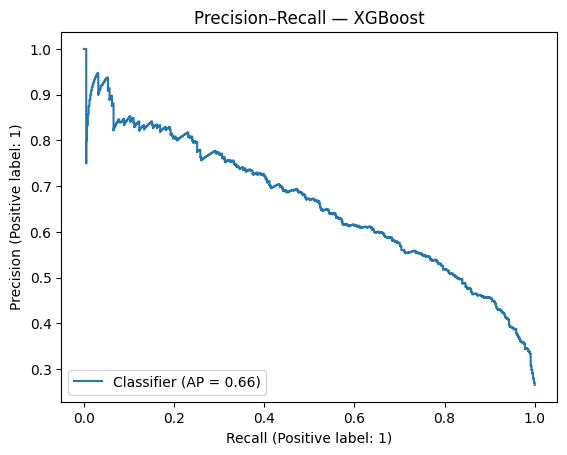

In [ ]:
if y_proba is not None:
    RocCurveDisplay.from_predictions(y_true_num, y_proba)
    plt.title(f"ROC — {model_name}")
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_true_num, y_proba)
    plt.title(f"Precision–Recall — {model_name}")
    plt.show()
else:
    print("Model does not expose probabilities; skipping ROC/PR curves.")

#### Threshold Selection

In [ ]:
chosen_th = None
if y_proba is not None:
    ths = np.linspace(0.10, 0.90, 17)
    rows = []
    for th in ths:
        y_hat = (y_proba >= th).astype(int)
        rows.append({
            "threshold": th,
            "precision": precision_score(y_true_num, y_hat, zero_division=0),
            "recall":    recall_score(y_true_num, y_hat, zero_division=0),
            "f1":        f1_score(y_true_num, y_hat, zero_division=0),
            "accuracy":  accuracy_score(y_true_num, y_hat)
        })
    th_df = pd.DataFrame(rows).set_index("threshold")
    display(th_df.style.format("{:.3f}"))

    # Example business rule: meet recall ≥ 0.70, then maximize precision (tie-breaker F1)
    target_recall = 0.70
    cand = th_df[th_df["recall"] >= target_recall]
    if not cand.empty:
        chosen_th = cand.sort_values(["precision","f1"], ascending=False).index[0]
        r = th_df.loc[chosen_th]
        print(f"Recommended threshold ≈ {chosen_th:.2f} (Recall {r['recall']:.2f}, Precision {r['precision']:.2f}, F1 {r['f1']:.2f})")
    else:
        chosen_th = th_df["f1"].idxmax()
        r = th_df.loc[chosen_th]
        print(f"No threshold met recall ≥ {target_recall:.0%}. Using F1-optimal {chosen_th:.2f} "
              f"(Recall {r['recall']:.2f}, Precision {r['precision']:.2f}, F1 {r['f1']:.2f})")
else:
    print("Threshold selection requires probabilities; skipped.")

,precision,recall,f1,accuracy
threshold,,,,
0.100000,0.403,0.943,0.565,0.614
0.150000,0.449,0.906,0.600,0.680
0.200000,0.476,0.852,0.610,0.711
0.250000,0.509,0.818,0.627,0.742
0.300000,0.541,0.772,0.636,0.765
0.350000,0.561,0.708,0.626,0.775
0.400000,0.598,0.658,0.626,0.792
0.450000,0.622,0.574,0.597,0.794
0.500000,0.670,0.513,0.581,0.804


Recommended threshold ≈ 0.35 (Recall 0.71, Precision 0.56, F1 0.63)


*The model outputs a probability of customer churn (0–1). The **decision threshold** (T) is the cutoff above which we classify a customer as “will churn.” Default is **T = 0.50**, but there’s no rule that 0.50 is optimal.*
*For retention use-cases, it’s preferable to catch more at-risk customers (higher recall), while keeping precision workable so offers aren’t wasted. So an example of this trade-off is that increasing T improves precision, but drops recall (at T = 0.55 precision is 0.70 and recall is 0.39). So we would choose T based on offer cost, team capacity, and target save-rate. Our recommendation would be to start with* **T = 0.35** *for the pilot. After that we'd like to review monthly and adjust based on measured incremental saves and contact capacity.*

#### Feature/Driver Insights

,feature,importance
14,Contract,0.071293
4,tenure,0.039431
17,MonthlyCharges,0.011561
7,InternetService,0.008138
18,TotalCharges,0.007638
8,OnlineSecurity,0.005185
16,PaymentMethod,0.003656
11,TechSupport,0.003045
6,MultipleLines,0.002083
15,PaperlessBilling,0.001186


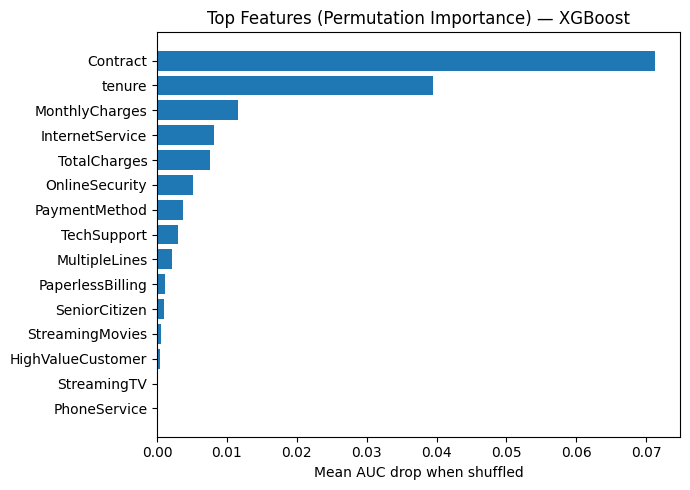

In [ ]:
result = permutation_importance(model, X_test, y_true_num, n_repeats=10, random_state=42, scoring="roc_auc")
imp = pd.DataFrame({
    "feature": getattr(X_test, "columns", np.arange(X_test.shape[1])),
    "importance": result.importances_mean
}).sort_values("importance", ascending=False).head(15)

display(imp)

plt.figure(figsize=(7,5))
plt.barh(imp["feature"][::-1], imp["importance"][::-1])
plt.title(f"Top Features (Permutation Importance) — {model_name}")
plt.xlabel("Mean AUC drop when shuffled")
plt.tight_layout()
plt.show()

*Driver insights explain which inputs most influenced predictions. This shuffles through one feature at a time and if model AUC drops a lot, that feature was important for prediction.*

**Month-to-month contracts**, **short tenure**, and **higher charges** *(without bundles) are associated with higher churn risk. It's important to note that the importance reflects predictive influence, and not causality.*